In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rd
from sklearn.datasets import make_circles,make_moons,make_classification,make_blobs,make_regression,make_biclusters
from pprint import pprint

In [10]:
class ReseauSimple:
	def __init__(self, archi=[2,3,1], xmod=False, init_met="default", seed=42):
		np.random.seed(seed)
		rd.seed(seed)
		if xmod:        
			self.X = np.random.randn(archi[0], 1)
            
		if init_met=="he":
			self.W_1 = np.random.randn(archi[1], archi[0]) * np.sqrt(2.0 / archi[0])
			self.W_2 = np.random.randn(archi[1], archi[2]) * np.sqrt(2.0 / archi[1])
			self.b_1 = np.random.randn(archi[1], archi[2]) * np.sqrt(2.0 / archi[1])
			self.b_2 = rd.normalvariate(mu=0, sigma=1)
		elif init_met=="xavier":
			self.W_1 = np.random.randn(archi[1], archi[0]) * np.sqrt(1.0 / archi[0])
			self.W_2 = np.random.randn(archi[1], archi[2]) * np.sqrt(1.0 / archi[1])
			self.b_1 = np.random.randn(archi[1], archi[2]) * np.sqrt(1.0 / archi[1])
			self.b_2 = rd.normalvariate(mu=0, sigma=1)
		elif init_met=="default":
			self.W_1 = np.random.randn(archi[1], archi[0])
			self.W_2 = np.random.randn(archi[1], archi[2])
			self.b_1 = np.random.randn(archi[1], archi[2])
			self.b_2 = rd.normalvariate(mu=0, sigma=1)
		else:
			raise ValueError("Invalid weight_init option. Choose 'default', 'he' or 'xavier'.")
            
		self.stock = [[self.W_1, self.W_2, self.b_1, self.b_2]]
        
        
	def sigmoid(self, z):
		return 1 / (1 + np.exp(-z))
    
	def ReLU(self, z):
		return np.maximum(0, z)

	def hidden(self, X, W_1, b):
		return self.sigmoid(W_1 @ X.reshape(-1,1) + b)

	def output(self, H, W_2, b):
		return self.sigmoid(W_2.T @ H + b)

	def delta_2(self, o, y):
		return float((o - y) * o * (1 - o))

	def delta_1(self, W_2, h, d2):
		return (W_2 * d2 * h * (1 - h)).reshape(-1, 1)

	def dJdW_2(self, h, d2):
		return d2 * h

	def dJdW_1(self, X, d1):
		return d1 @ X.T

	def train(self, data, labels, passages=10, lr=0.01):
		n=passages//50
		for j in range(passages):
			#n = int(np.ceil(100*j/passages))
			n = round(100*(j+1)/passages)
			#print(f'|{n*"█"}{(100-n)*" "}|', end='\r')
			print(f'{n*"▣"}{(100-n)*"▢"}', end='\r')
			for i in range(data.shape[0]):
		
				h = self.hidden(data[i], self.W_1, self.b_1)
				o = self.output(h, self.W_2, self.b_2)

				#backward propagation
				
				d2 = self.delta_2(o, labels[i])
				djdb_2 = d2
				d1 = self.delta_1(self.W_2, h, d2)
				djdb_1 = d1
				dj2 = self.dJdW_2(h, d2)
				dj1 = self.dJdW_1(data[i].reshape(-1, 1), d1)
				
				self.W_2 -= lr * dj2
				self.W_1 -= lr * dj1
				self.b_2 -= lr * djdb_2
				self.b_1 -= lr * djdb_1

			self.stock.append([np.copy(self.W_1), np.copy(self.W_2), np.copy(self.b_1), np.copy(self.b_2)])

	def predict(self, X, etape=-1):
		h = self.hidden(X.reshape(-1, 1), self.stock[etape][0], self.stock[etape][2])
		o = self.output(h, self.stock[etape][1], self.stock[etape][3])
		return float(o)
		
	def predict_list(self, X, etape=-1):
		y_hat = []
		for x in X:
			y_hat.append(self.predict(x, etape=etape))
		return y_hat

	def visualisation(self, data, labels, savemod=False, folder="Saves", etape=-1, nb_levels=10):
		plt.figure(figsize=(12,8))
		hh = .02
		x_r = data[:, 0].max() - data[:, 0].min()
		y_r = data[:, 1].max() - data[:, 1].min()
		x_min, x_max = data[:, 0].min() - x_r/10, data[:, 0].max() + x_r/10
		y_min, y_max = data[:, 1].min() - y_r/10, data[:, 1].max() + y_r/10
		xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100),
							np.arange(y_min, y_max, (y_max-y_min)/100))
		Z = np.array(self.predict_list(np.c_[xx.ravel(), yy.ravel()], etape=etape))
		Z = Z.reshape(xx.shape)

		contour = plt.contourf(xx, yy, Z, alpha=1, levels=[i/nb_levels for i in range(nb_levels+1)])
		sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels).set_aspect('equal')

		plt.colorbar(contour, label = 'prediction')
		if savemod:
            img_name = f'./{folder}/fig{etape:03d}.svg'
			plt.savefig(img_name, format='svg')
            return img_name
		else:
			plt.show()
		
	def history(self):
		return self.stock

In [11]:
def cluster(pos, size=100, etendue=(2, 2)):
	c = []
	for n in range(1, size+1):
		x = rd.gauss(pos[0], etendue[0])
		y = rd.gauss(pos[1], etendue[1])
		c.append((x, y))
	
	return c

def clans1v1(center=(0,0), dist=40, etendue=(2, 2)):
	p = np.array(cluster((center[0]+dist/2, center[1]+dist/2), size = 1000, etendue=etendue)+cluster((center[0]-dist/2, center[1]-dist/2), size = 1000, etendue=etendue))
	l = [1 for _ in range(1000)] + [0 for _ in range(1000)]
	return p, l

def clans2v2(center=(0,0), dist=40, etendue=(2, 2)):
	p = np.array(cluster((center[0]+dist/2, center[1]+dist/2), size = 1000, etendue=etendue)+cluster((center[0]-dist/2, center[1]-dist/2), size = 1000, etendue=etendue)+cluster((center[0]-dist/2, center[1]+dist/2), size = 1000, etendue=etendue)+cluster((center[0]+dist/2, center[1]-dist/2), size = 1000, etendue=etendue))
	l = [1 for _ in range(2000)] + [0 for _ in range(2000)]
	return p, l 

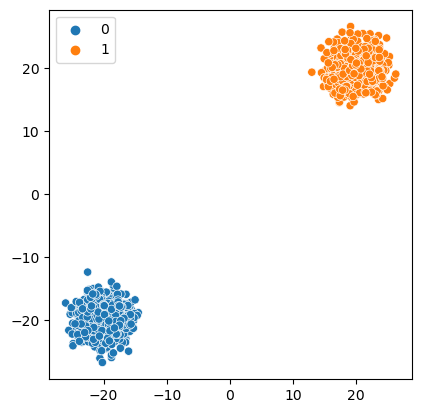

In [12]:
data, label = clans2v2(etendue=(2,2))
data, label = clans1v1()
#data, label = make_circles(100000, noise= 0.07, factor = 0.1, random_state = 42)
#data, label = make_moons(100000, noise=0.07, random_state=42)
#data, label = make_classification(100000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
#data, label = make_blobs(100000, n_features=2, centers=2, random_state=42)
#data, label = make_regression(100000, n_features=2, noise=0.1, random_state=42)
fig=sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=label)
fig.set_aspect('equal')

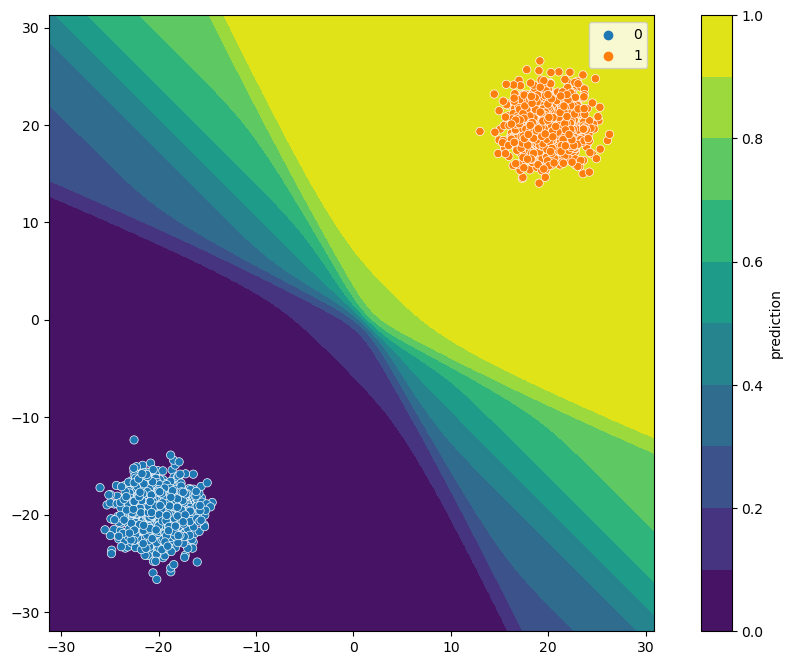

In [13]:
er = ReseauSimple(xmod=True)
for i in range(10:):
    er.train(data,label,passages=1)
    er.visualisation(data,label, savemod=True)

In [79]:
r1 = ReseauSimple(archi=[2,3,1], xmod=True, init_met="default")
r2 = ReseauSimple(archi=[2,3,1], xmod=True, init_met="he")
r3 = ReseauSimple(archi=[2,3,1], xmod=True, init_met="xavier")
r1.train(data, label, passages=100, lr=0.01)
r2.train(data, label, passages=100, lr=0.01)
r3.train(data, label, passages=100, lr=0.01)

#r.visualisation(data, label)
#for i in range(101):
 #   r.visualisation(data, label, savemod=True, etape=i, folder="testd")

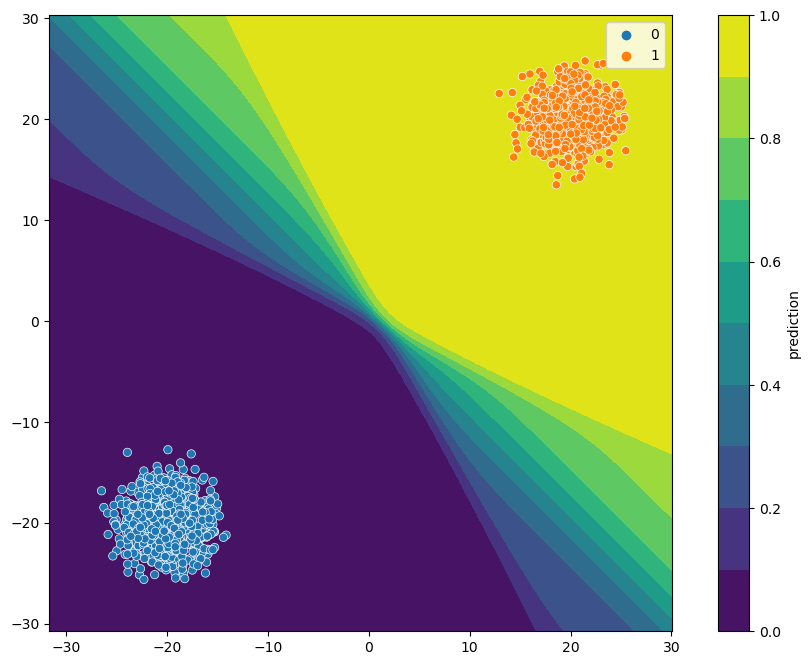

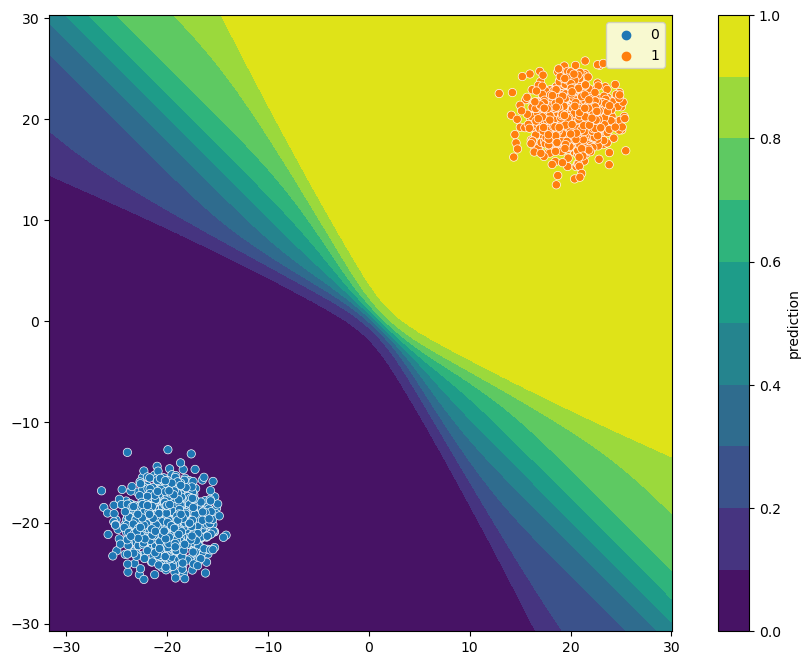

In [88]:
e=-1
r1.visualisation(data, label, etape=e)
r2.visualisation(data, label, etape=e)
r3.visualisation(data, label, etape=e)

In [6]:
tests = {}
for n in range(1,13):
    for lr in [0.1, 0.01, 0.001, 0.0001]:
        for xmod in [True, False]:
            break
            modele = ReseauSimple(archi=[2,n,1], xmod=xmod)
            modele.train(data, label, passages=100, lr=lr)
            tests[f'{n}-{lr}-{xmod}'] = modele
            print(f'{n}-{lr}-{xmod}')
            modele.visualisation(data, label)

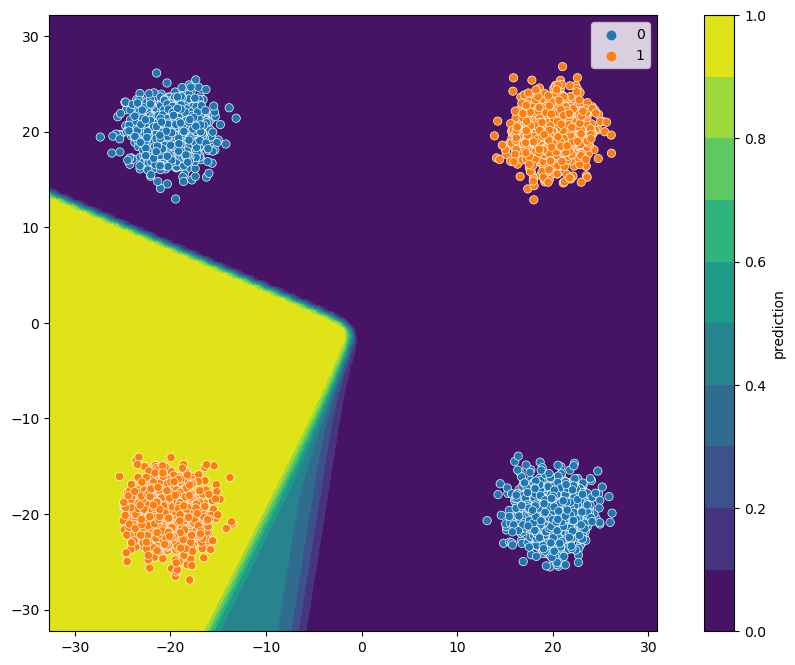

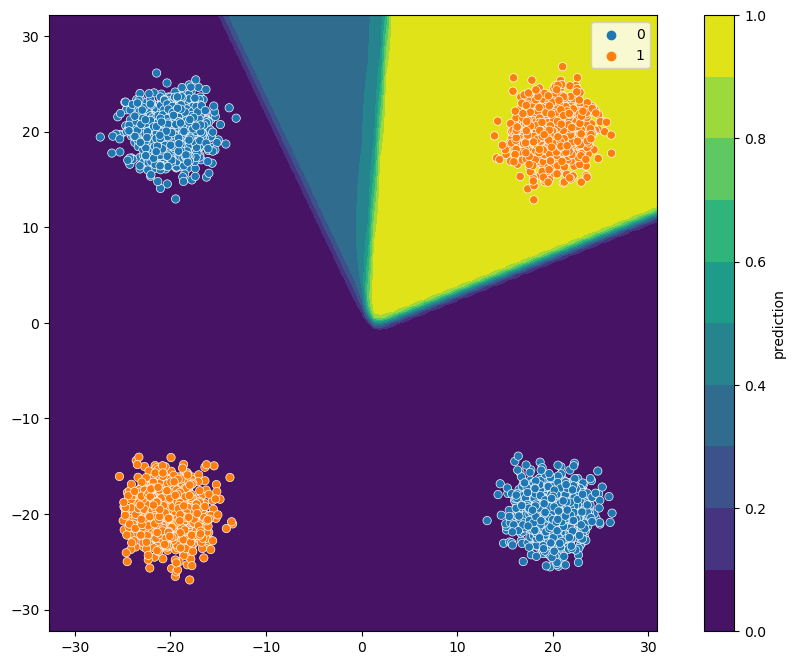

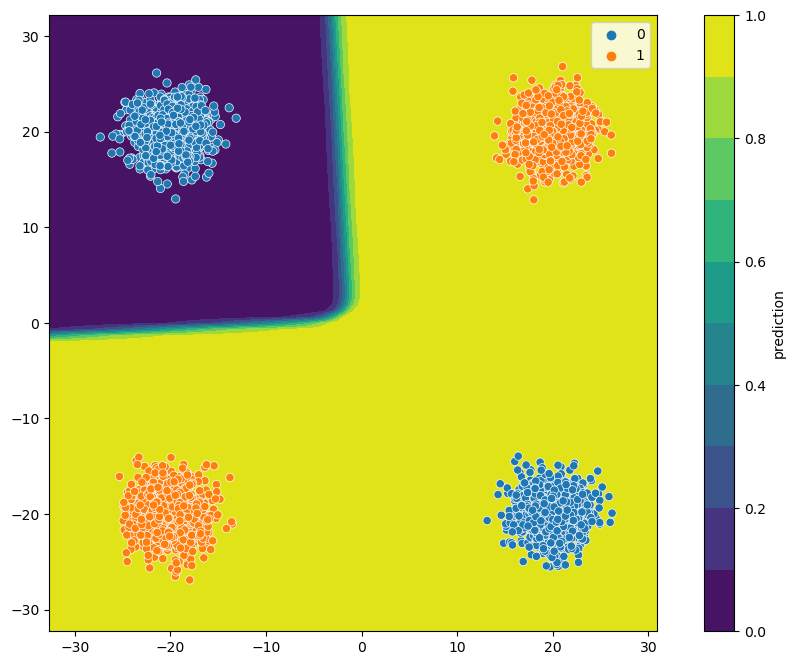

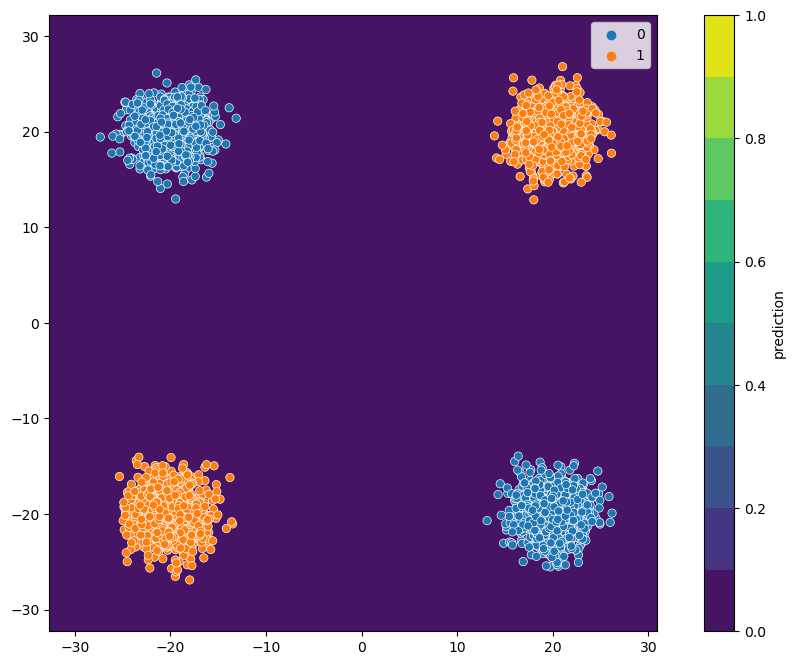

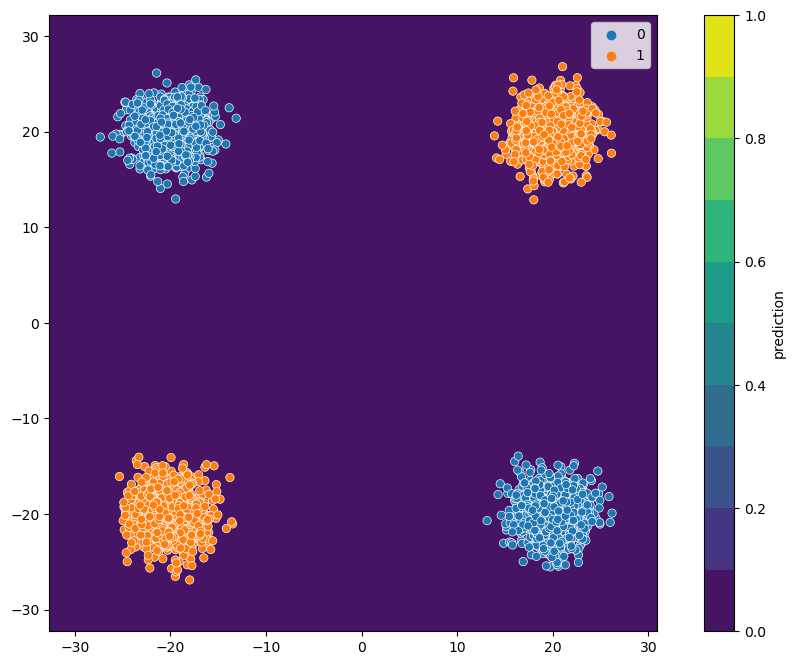

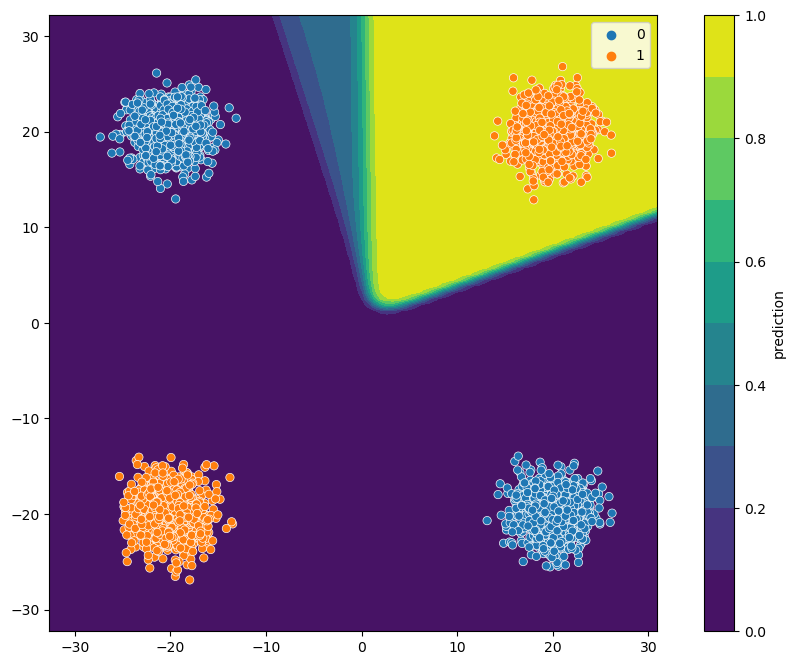

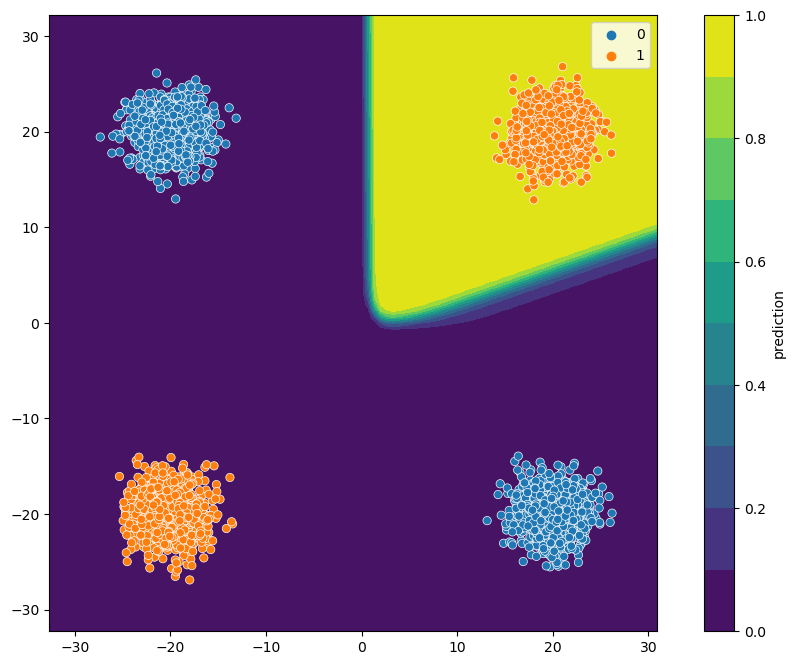

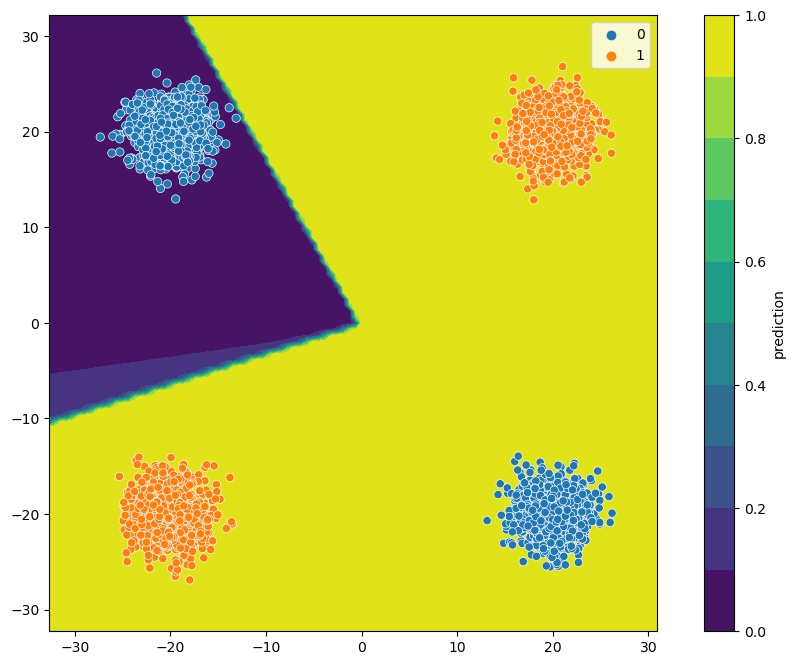

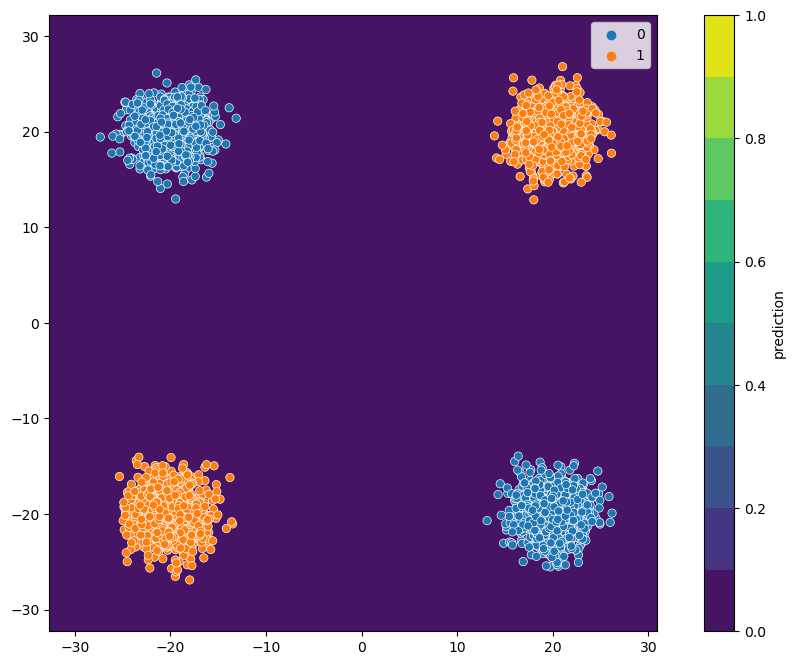

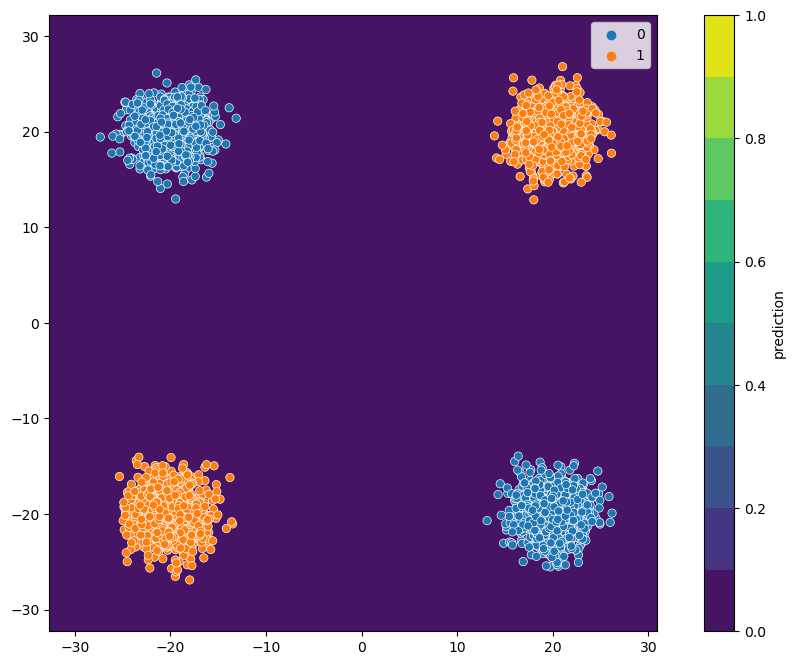

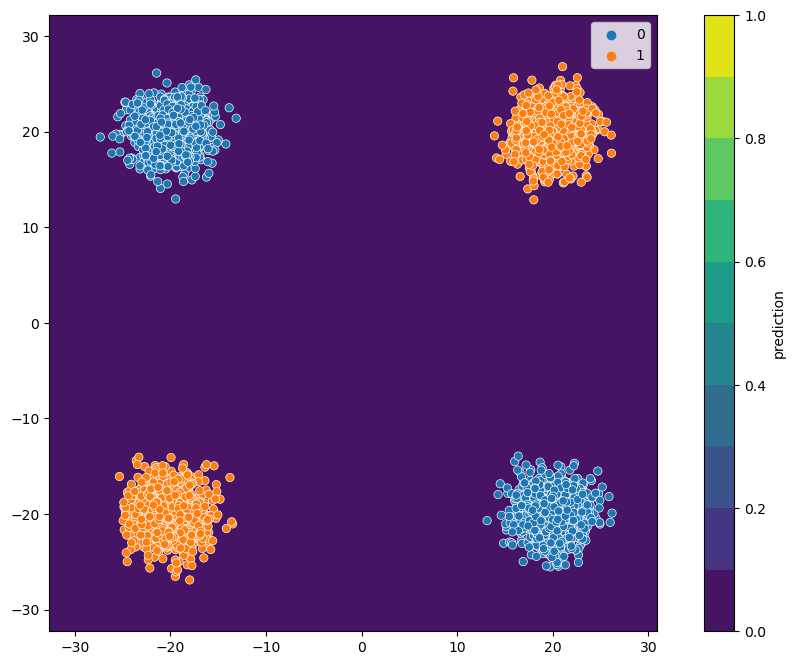

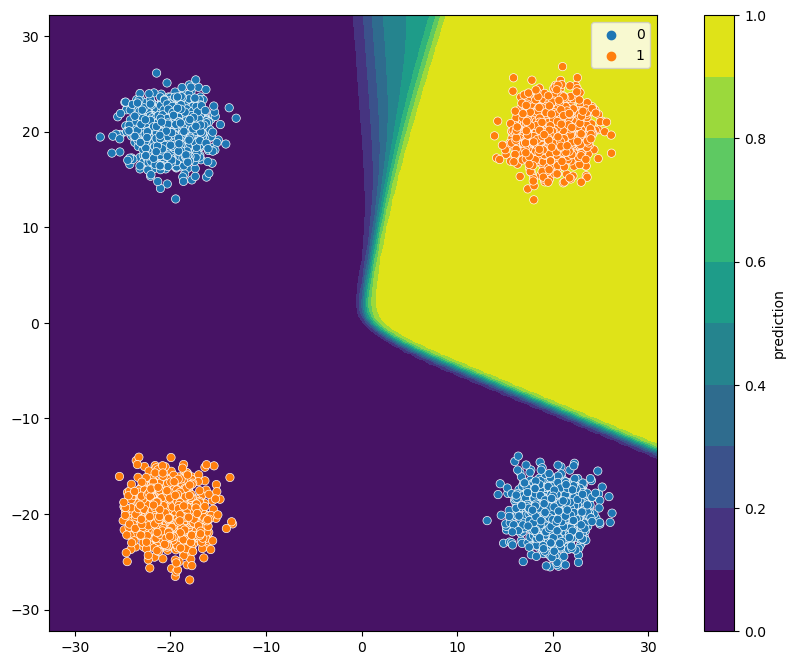

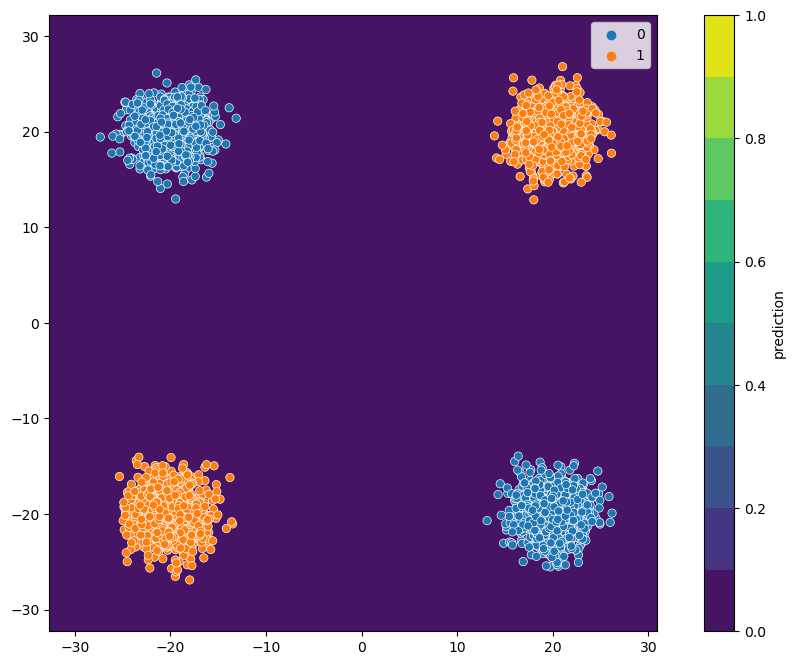

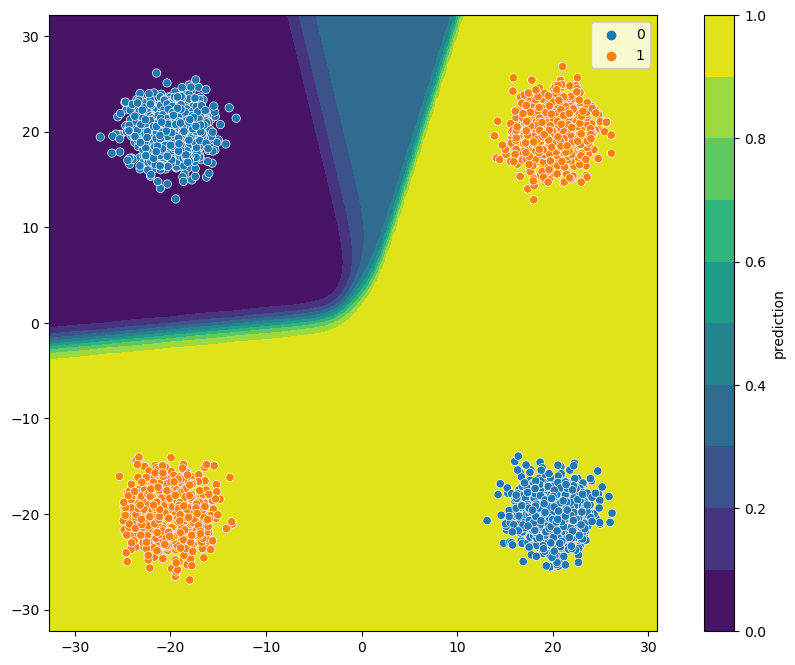

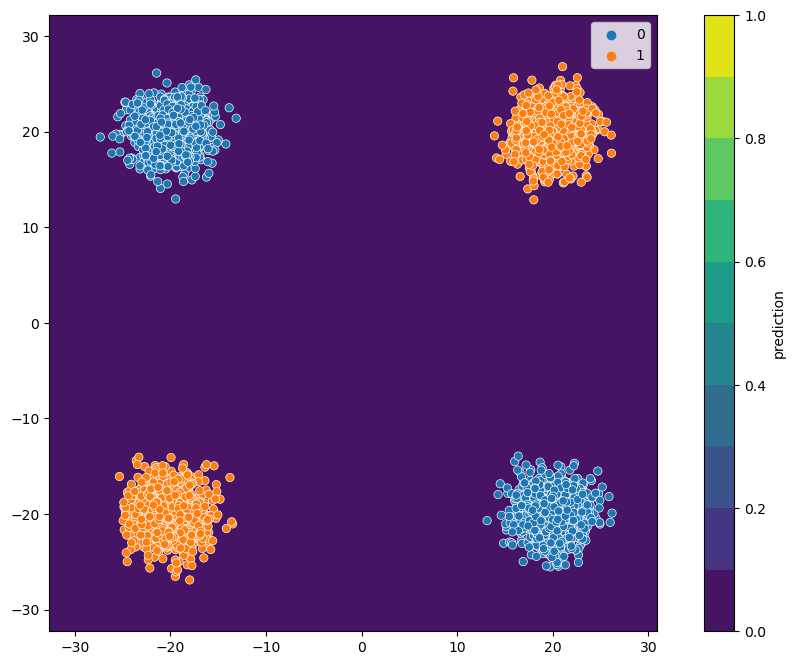

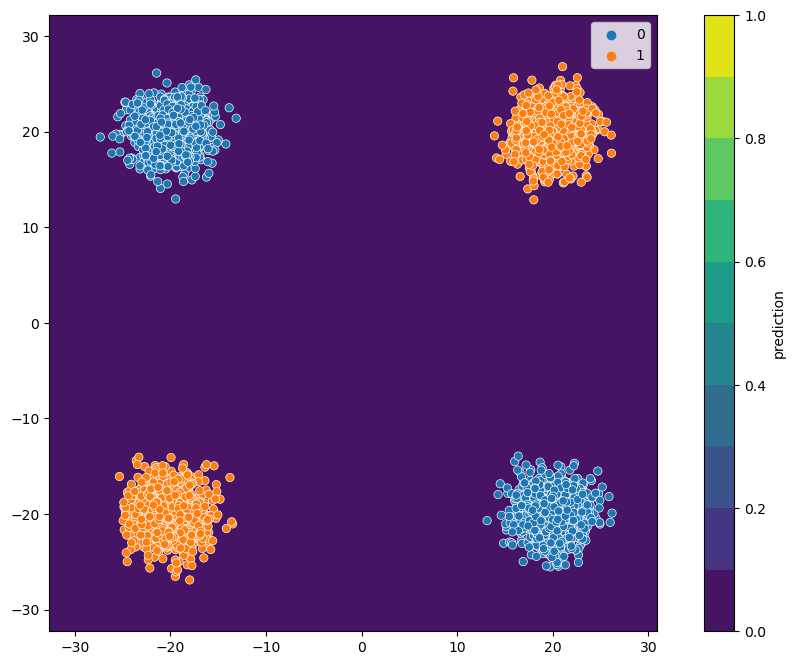

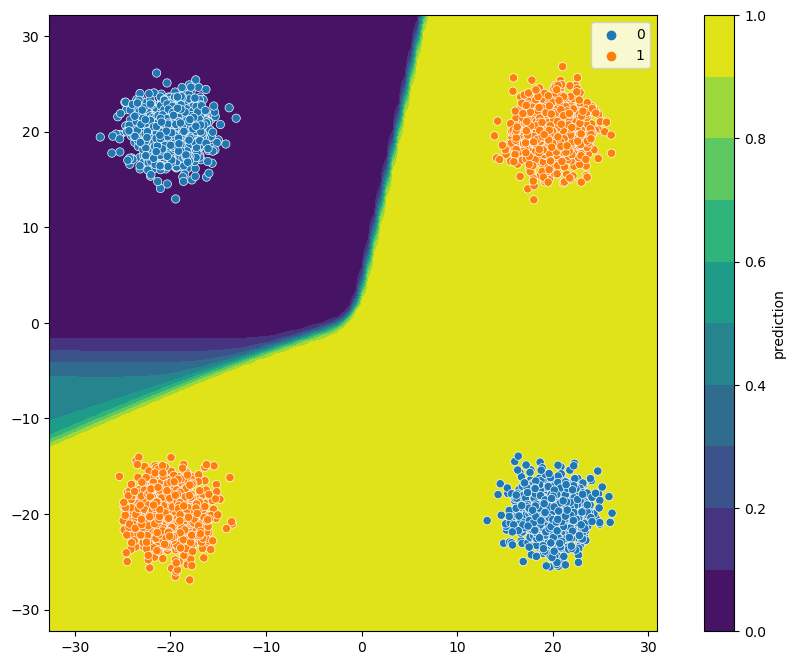

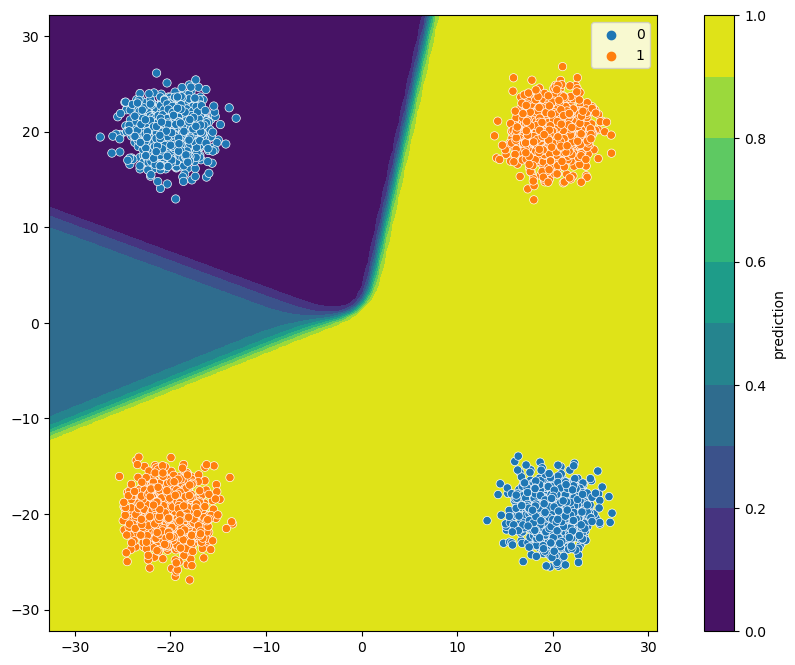

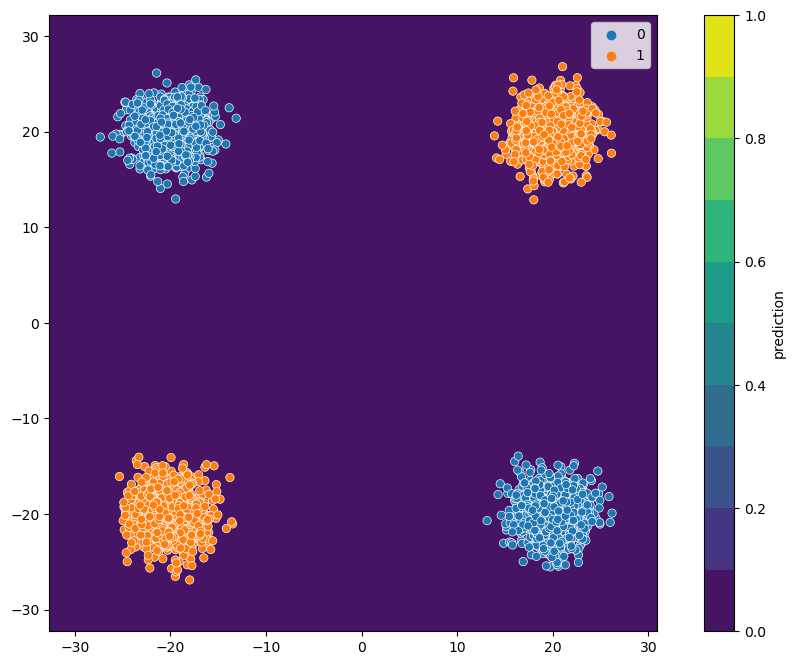

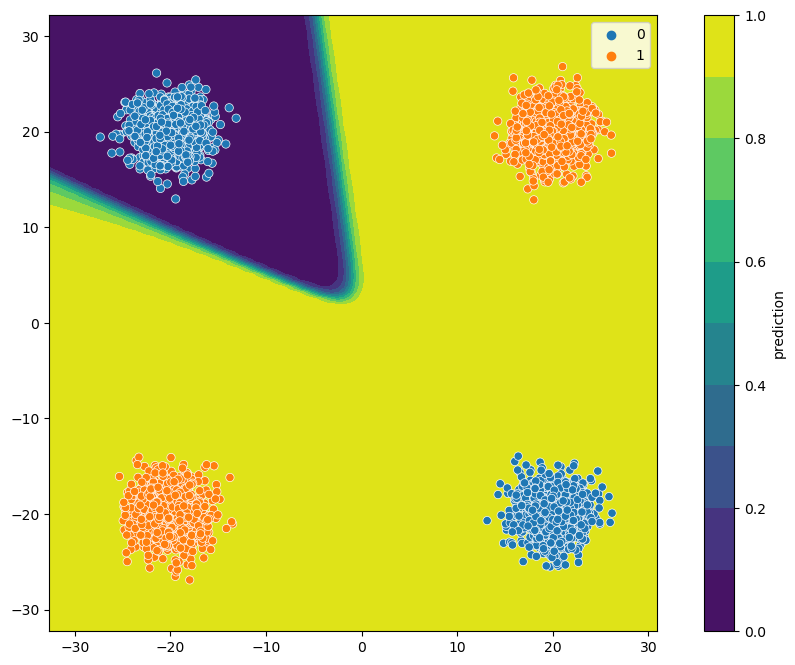

KeyboardInterrupt: 

In [97]:
for seed in range(50):
    r = ReseauSimple(seed=seed, xmod=True)
    r.train(data,label,passages=50, lr=1)
    r.visualisation(data, label)